In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box
import shapely
from matplotlib import colors
import matplotlib.patches as mpatches

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-dtperez1')

In [4]:
comuna = gpd.read_file('COMUNA_C17.shp').to_crs(4326)

In [5]:
rancagua = comuna[comuna['NOM_COMUNA'] == 'RANCAGUA']
ran = rancagua.geometry

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

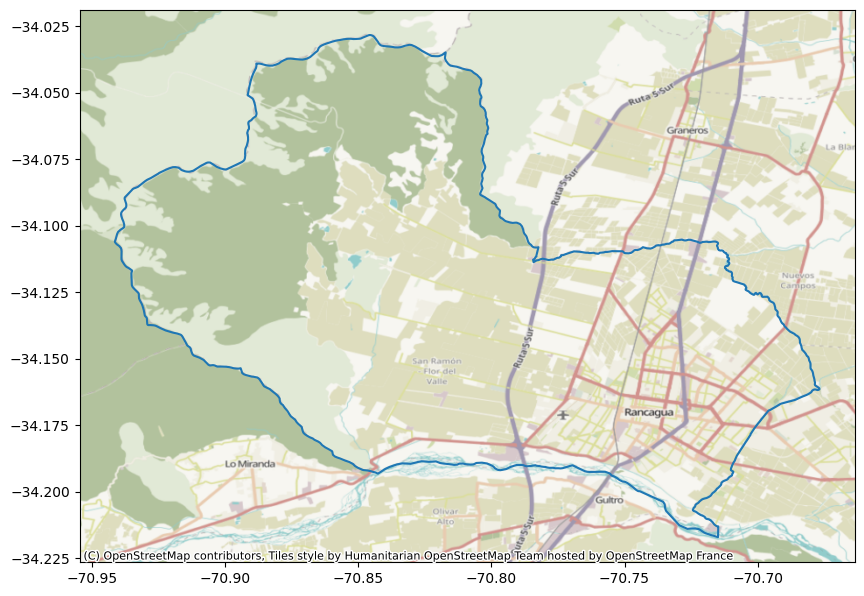

In [7]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ran.boundary.plot(ax=ax)
ctx.add_basemap(ax,crs=comuna.crs.to_string())

In [8]:
minx,miny,maxx,maxy=ran.to_crs(4326).geometry.total_bounds
xy=[[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy]]

aoi = ee.Geometry.Polygon(xy)
aoi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -70.94151720199994,
              -34.21701446299994
            ],
            [
              -70.67678642999994,
              -34.21701446299994
            ],
            [
              -70.67678642999994,
              -34.02834227899996
            ],
            [
              -70.94151720199994,
              -34.02834227899996
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [10]:
collection = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(aoi)
images=collection.aggregate_array('system:id').getInfo()
len(images) #526

526

In [11]:
def getAOI_latlon(dat,crs=4326):
    minx,miny,maxx,maxy=dat.to_crs(crs).geometry.total_bounds
    xy=[[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy]]
    aoi = ee.Geometry.Polygon(xy)
    return(aoi)

def getImage(aoi,dates,clouds=20,mosaic=False):
    collection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(aoi).filterDate(dates[0],dates[1])
    collection = collection.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',clouds));
    images=collection.aggregate_array('system:id').getInfo()
    return(images)

In [24]:
dates=['1969-12-15','2080-03-25']
aoif = getAOI_latlon(ran)
collection_2 = collection.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 100))
#images_fil = getImage(aoif,dates,clouds=100,mosaic=True) 
images_fil

[]

In [27]:
def fmask(image):
       qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
       opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
       return image.addBands(opticalBands, None, True).updateMask(qaMask)

In [30]:
sin_nubes = []
for imagen in images:
    sin_nubes.append(fmask(ee.Image(imagen)))

In [41]:
import geemap.colormaps as cm
Map = geemap.Map(center=[0.5 * (miny + maxy),0.5 * (minx + maxx)], zoom=12)


vis_params = {"min": 0, "max": 0.3, "bands": ["SR_B3", "SR_B2", "SR_B1"]}

#vis_params = {"min": 0, "max": 4000, "bands": ["B3", "B4", "B2"]}

Map.addLayer(sin_nubes[100], vis_params,name='Imagen')

Map.addLayer(aoi,name='aoi',shown=True, opacity = 0.4)

Map

Map(center=[-34.12267837099995, -70.80915181599994], controls=(WidgetControl(options=['position', 'transparent…

In [65]:
año = sin_nubes[1].date().get('year') 
ano = año.getInfo()
print(ano == 2022)

True
